<a href="https://colab.research.google.com/github/robgon-art/molding-the-imagination/blob/main/MVDream_Cubist_Head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/bytedance/MVDream

Cloning into 'MVDream'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 64 (delta 11), reused 5 (delta 5), pack-reused 46
Receiving objects: 100% (64/64), 49.80 KiB | 6.22 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
%cd MVDream

/content/MVDream


In [ ]:
!pip install .

Processing /content/MVDream
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
  Created wheel for mvdream: filename=mvdream-0.0.1-py3-none-any.whl size=40717 sha256=33958732fdc775901684fd5b9a853a825ed9b0ffdf7df6d6c34aaf3cc0146875
  Stored in directory: /tmp/pip-ephem-wheel-cache-3o12h07d/wheels/6f/e9/e5/0c0054ef7b265d553caea0ce6a641b0470a69b31ac304cda66
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=b533b7d8bf6a7

In [ ]:
import sys
sys.path.insert(0, "/content/MVDream/mvdream")

In [ ]:
from mvdream.model_zoo import build_model
model = build_model("sd-v2.1-base-4view") #sd-v2.1-base-4view-ipmv.pt

Loading model from config: sd-v2-base.yaml


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

No module 'xformers'. Proceeding without it.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


sd-v2.1-base-4view.pt:   0%|          | 0.00/5.22G [00:00<?, ?B/s]

Loading model from cache file: /root/.cache/huggingface/hub/models--MVDream--MVDream/snapshots/d14ac9d78c48c266005729f2d5633f6c265da467/sd-v2.1-base-4view.pt


In [ ]:
import os
import sys
import random
import argparse
from PIL import Image
import numpy as np
from omegaconf import OmegaConf
import torch

from mvdream.camera_utils import get_camera
from mvdream.ldm.util import instantiate_from_config
from mvdream.ldm.models.diffusion.ddim import DDIMSampler
from mvdream.model_zoo import build_model

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def t2i(model, image_size, prompt, uc, sampler, step=20, scale=7.5, batch_size=8, ddim_eta=0., dtype=torch.float32, device="cuda", camera=None, num_frames=1, seed=42):
    if type(prompt)!=list:
        prompt = [prompt]
    with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
        c = model.get_learned_conditioning(prompt).to(device)
        c_ = {"context": c.repeat(batch_size,1,1)}
        uc_ = {"context": uc.repeat(batch_size,1,1)}
        if camera is not None:
            c_["camera"] = uc_["camera"] = camera
            c_["num_frames"] = uc_["num_frames"] = num_frames

        shape = [4, image_size // 8, image_size // 8]
        samples_ddim, _ = sampler.sample(S=step, conditioning=c_,
                                        batch_size=batch_size, shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=scale,
                                        unconditional_conditioning=uc_,
                                        eta=ddim_eta, x_T=None, seed=seed)
        x_sample = model.decode_first_stage(samples_ddim)
        x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
        x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()

    return list(x_sample.astype(np.uint8))

In [ ]:
device = "cuda"
model.device = device
model.to(device)
model.eval()

num_views = 4

sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)
print("load t2i model done . ")

camera = get_camera(num_views, azimuth_start=-30).cuda()

load t2i model done . 


DDIM Sampler: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


a 3d-printed Cubist-styled sculpture of a male bust, in light-gray plastic, on a simple light-gray pedestal, dark-gray background



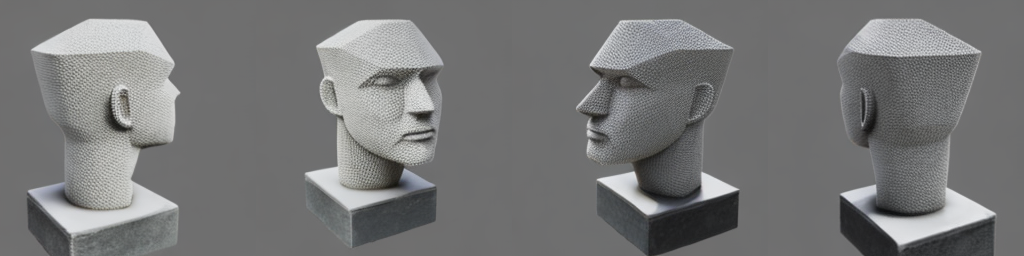

In [ ]:
from mvdream.camera_utils import get_camera
from IPython.display import display

# prompt = "a 3d-printed sculpture of a pug, on a simple pedestal, in light-gray plastic, dark-gray background"
# prompt = "a 3d-printed modern abstract sculpture with rotated, sliced spheres, in light-gray plastic, on a simple pedestal, dark-gray background"
prompt = "a 3d-printed Cubist-styled sculpture of a male bust, in light-gray plastic, on a simple light-gray pedestal, dark-gray background"

seed = 12
set_seed(seed)
img = t2i(model, prompt=prompt, uc=uc, sampler=sampler, step=100, scale=10, batch_size=num_views,
              ddim_eta=0.0, device=device, camera=camera, num_frames=num_views, image_size=256, seed=seed)

images = np.concatenate(img, 1)
pil_image = Image.fromarray(images, 'RGB')
print(prompt)
print()
# print("             Left                             Front                            Right                             Back")
display(pil_image)

In [ ]:
pil_image = Image.fromarray(img[1], 'RGB')
pil_image.save("output.png")

In [ ]:
for i, im in enumerate(img):
  pil_image = Image.fromarray(im, 'RGB')
  pil_image.save("/content/image_"+str(i)+".jpg")